In [1]:
from fastai.vision.all import *

In [5]:
import torch
from torch import tensor
from torchvision.models.resnet import resnet34
import requests

import pandas as pd
from fastcore.transform import Pipeline
from fastcore.xtras import Path # @patched Pathlib.path

from fastai.data.core import Datasets
from fastai.data.block import DataBlock, MultiCategoryBlock
from fastai.data.external import URLs, untar_data
from fastai.data.transforms import (
    ColReader,
    IntToFloatTensor, 
    MultiCategorize,
    Normalize, 
    OneHotEncode, 
    RandomSplitter,
    RegexLabeller,
    get_image_files
)

from fastai.metrics import accuracy_multi

from fastai.vision.augment import aug_transforms, RandomResizedCrop
from fastai.vision.core import PILImage
from fastai.vision.learner import vision_learner
from fastai.learner import Learner
from fastai.callback.schedule import Learner # @patched Learner functions like lr_find and fit_one_cycle

In [6]:
path = untar_data(URLs.PETS)/'images'

In [7]:
fnames = get_image_files(path/'images')
pat = r'(.+)_\d+.jpg$'
item_tfms = RandomResizedCrop(460, min_scale=0.75, ratio=(1.,1.))
batch_tfms = [*aug_transforms(size=224, max_warp=0), Normalize.from_stats(*imagenet_stats)]
bs=64

In [8]:
pets = DataBlock(blocks=(ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(),
                 get_y=RegexLabeller(pat = r'/([^/]+)_\d+.*'),
                 item_tfms=item_tfms,
                 batch_tfms=batch_tfms)

In [9]:
def label_to_list(o): return [o]

In [10]:
multi_pets = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(),
    get_y=Pipeline(
        [RegexLabeller(pat = r'/([^/]+)_\d+.*'), label_to_list]
    ),
    item_tfms=item_tfms,
    batch_tfms=batch_tfms
)

In [11]:
dls = multi_pets.dataloaders(path, bs=32)

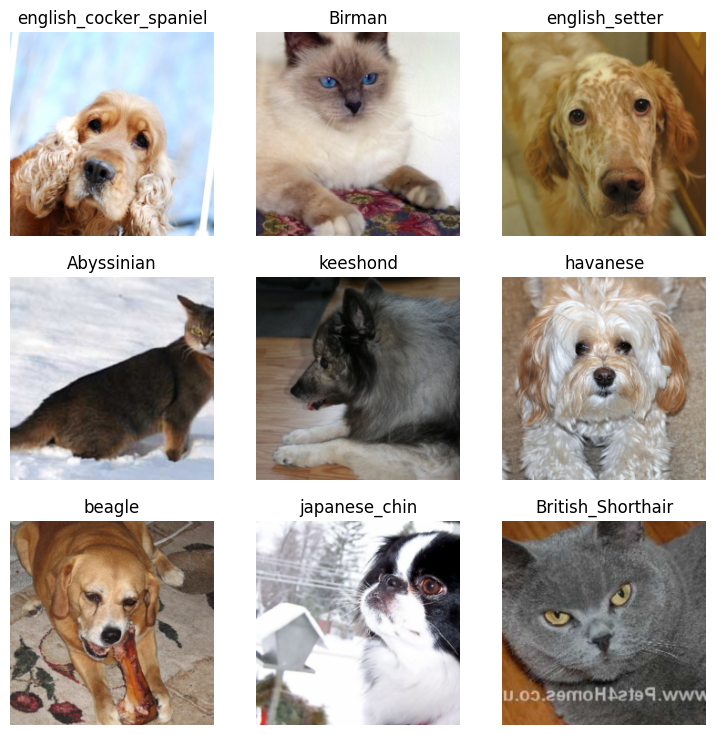

In [12]:
dls.show_batch()

In [13]:
train_idxs, valid_idxs = RandomSplitter()(get_image_files(path))

In [14]:
tfms = [
    [PILImage.create],
    [
        RegexLabeller(pat = r'/([^/]+)_\d+.*'),
        label_to_list,
        MultiCategorize(vocab=list(dls.vocab)),
        OneHotEncode(len(dls.vocab))
    ]
]

In [15]:
dsets = Datasets(get_image_files(path), tfms=tfms, splits=[train_idxs, valid_idxs])

In [16]:
dsets[0]

(PILImage mode=RGB size=600x400,
 TensorMultiCategory([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                      0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                      0., 0., 0., 0., 0., 0., 0.]))

In [17]:
dls = dsets.dataloaders(
    after_item=[ToTensor(), RandomResizedCrop(460, min_scale=.75)],
    after_batch=[IntToFloatTensor(), *aug_transforms(size=224, max_warp=0), Normalize.from_stats(*imagenet_stats)],
    bs=32
)

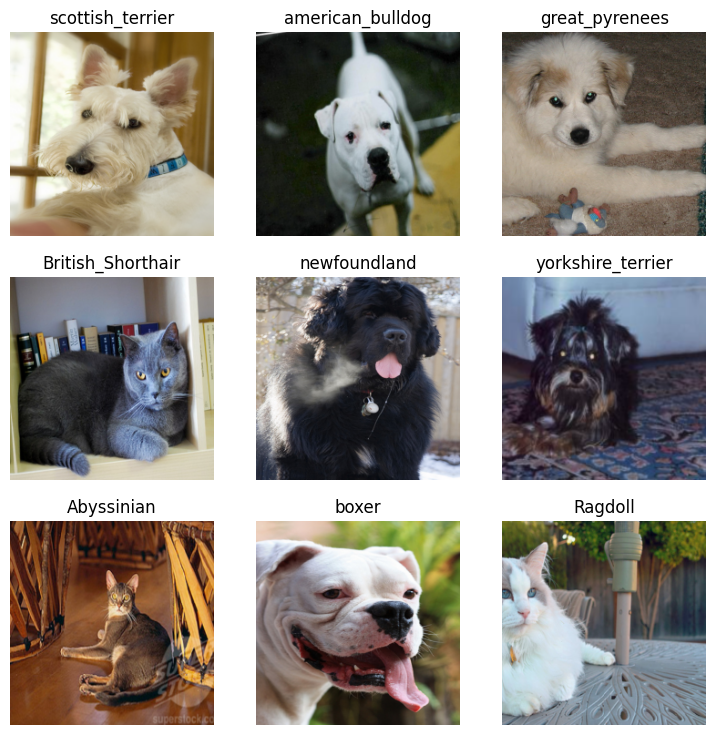

In [18]:
dls.show_batch()

In [19]:
learn = vision_learner(dls, resnet34, metrics=[partial(accuracy_multi, thresh=0.95)])

In [20]:
learn.fine_tune(4, 2e-3)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.420909,0.069116,0.973796,01:39


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.052613,0.023234,0.981330,01:36
1,0.025952,0.012518,0.990144,01:41
2,0.015267,0.010439,0.992283,01:47
3,0.010348,0.009812,0.992576,01:39


In [21]:
learn.loss_func.thresh = 0.95

In [22]:
PERSIAN_CAT_URL = "https://azure.wgp-cdn.co.uk/app-yourcat/posts/iStock-174776419-1.jpg"

In [23]:
response = requests.get(PERSIAN_CAT_URL)
im = PILImage.create(response.content)

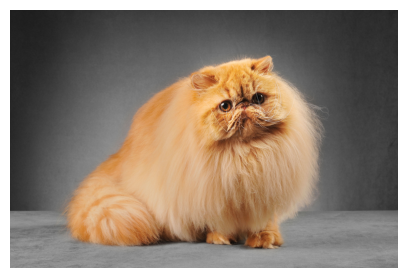

In [24]:
im.show();

In [25]:
learn.predict(im)[0]

(#1) ['Persian']

In [26]:
DONKEY_URL = "https://cdn.britannica.com/68/143568-050-5246474F/Donkey.jpg"
response = requests.get(DONKEY_URL)
learn.predict(response.content)[0]

(#0) []

In [29]:
# An image of a husky dog

dog_url = "https://img.freepik.com/premium-photo/big-huskey-dog-park_179755-946.jpg?w=826"
response = requests.get(dog_url)
learn.predict(response.content)[0]

(#1) ['samoyed']

In [30]:
from fastai.vision.all import *

from sklearn.model_selection import StratifiedKFold

In [31]:
path = untar_data(URLs.PETS)
fnames = get_image_files(path/'images')
pat = r'(.+)_\d+.jpg$'
item_tfms = [RandomResizedCrop(460, min_scale=0.75, ratio=(1.,1.)), ToTensor()]
batch_tfms = [IntToFloatTensor(), *aug_transforms(size=224, max_warp=0), Normalize.from_stats(*imagenet_stats)]
batch_size = 64

In [32]:
random.shuffle(fnames)

train_fnames = [filename for filename in fnames[:int(len(fnames) * .9)]]
test_fnames = [filename for filename in fnames[int(len(fnames) * .9):]]

In [33]:
vocab = list(map(RegexLabeller(pat=r'/([^/]+)_\d+.*'), train_fnames))

In [34]:
pipe = Pipeline([
    RegexLabeller(pat=r'/([^/]+)_\d+.*'), Categorize(vocab=vocab)
])

In [35]:
labels = list(map(pipe, train_fnames))

In [36]:
splits = []
skf = StratifiedKFold(n_splits=10, shuffle=True)
for _, valid_indexes in skf.split(
    np.zeros(len(labels)), labels
):
    split = IndexSplitter(valid_indexes)
    splits.append(split)

In [37]:
valid_pcts = []
test_preds = []

In [38]:
def train(splitter:IndexSplitter):
    "Trains a single model over a set of splits based on `splitter`"
    dset = Datasets(
        train_fnames,
        tfms = [
            [PILImage.create], 
            [RegexLabeller(pat=r'/([^/]+)_\d+.*'), Categorize]
        ],
        splits = splitter(train_fnames)
    )
    dls = dset.dataloaders(
        bs=batch_size,
        after_item=item_tfms,
        after_batch=batch_tfms
    )
    learn = vision_learner(dls, resnet34, metrics=accuracy)
    learn.fit_one_cycle(1)
    valid_pcts.append(learn.validate()[1])
    dl = learn.dls.test_dl(test_fnames)
    preds, _ = learn.get_preds(dl=dl)
    test_preds.append(preds)

In [39]:
for splitter in splits:
    train(splitter)

epoch,train_loss,valid_loss,accuracy,time
0,1.119777,0.359857,0.887387,01:07


epoch,train_loss,valid_loss,accuracy,time
0,1.176864,0.370502,0.876692,01:08


epoch,train_loss,valid_loss,accuracy,time
0,1.173793,0.322936,0.897744,01:08


epoch,train_loss,valid_loss,accuracy,time
0,1.109675,0.387358,0.879699,01:08


epoch,train_loss,valid_loss,accuracy,time
0,1.186707,0.329271,0.888722,01:06


epoch,train_loss,valid_loss,accuracy,time
0,1.144908,0.339394,0.894737,01:07


epoch,train_loss,valid_loss,accuracy,time
0,1.169192,0.413206,0.879699,01:08


epoch,train_loss,valid_loss,accuracy,time
0,1.144908,0.347600,0.899248,01:07


epoch,train_loss,valid_loss,accuracy,time
0,1.184135,0.348249,0.891729,01:07


epoch,train_loss,valid_loss,accuracy,time
0,1.172506,0.388584,0.882707,01:06


In [40]:
test_labels = torch.stack([pipe(fname) for fname in test_fnames])
accuracy(test_preds[0], test_labels)

TensorBase(0.8823)

In [41]:
for preds in test_preds:
    print(accuracy(preds, test_labels))

TensorBase(0.8823)
TensorBase(0.8931)
TensorBase(0.8985)
TensorBase(0.9053)
TensorBase(0.9012)
TensorBase(0.8985)
TensorBase(0.8958)
TensorBase(0.8972)
TensorBase(0.8917)
TensorBase(0.8972)


In [42]:
votes = torch.stack(test_preds, dim=-1).sum(-1) / 5

In [43]:
accuracy(votes, test_labels)

TensorBase(0.9256)